# ECG recognition using machine learning classifiers

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
#from thundersvm import * #pararell
from sklearn.svm import LinearSVC
from sklearn import tree
import itertools
import graphviz
import copy
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn import datasets
from sklearn.decomposition import PCA

In [3]:
ECG_df = pd.read_csv('sample_Electrocardiogram.csv')
diagnosis_df = pd.read_csv('sample_Diagnosis.csv')
person_df = pd.read_csv('sample_person.csv')

### Useful Funcions

In [3]:
#Transfer icm-10 diagnosis group of codes of type of heart or circular system disease to simpler one
def reduceDiagnosis(diagnosis):
    number = int(diagnosis[1:3])
    if not diagnosis[0] == "I":
        return "Healthy"
    if number < 3:
        #return "Acute rheumatic fever"
        return "AR"
    if number < 9:
        #return "Chronic rheumatic heart diseases"
        return "CR"
    if number < 16:
        #return "Hypertensive diseases"
        return "HD"
    if number < 25:
        #return "Ischemic heart diseases"
        return "IH"
    if number < 28:
        #return "Pulmonary heart disease and diseases of pulmonary circulation"
        return "PH"
    if number < 52:
        #return "Other forms of heart disease"
        return "OH"
    if number < 69:
        #return "Cerebrovascular diseases"
        return "CD"
    if number < 79:
        #return "Diseases of arteries, arterioles and capillaries"
        return "DA"
    if number < 89:
        #return "Diseases of veins, lymphatic vessels and lymph nodes, not elsewhere classified"
        return "DV"
    #return "Other and unspecified disorders of the circulatory system"
    return "OC"

def toNumbers(x):
    if x in diagnosis_names_short:
        return diagnosis_names_short.index(x)
    elif x in diagnosis_names_short_sick:
        return diagnosis_names_short_sick.index(x)
    else: 
        print(x)
        raise Exception("not in list")

In [4]:
feature_names=["PR", "RR", "QRS", "QT", "QTc", "P_wave_axis", "QRS_axis", "T_wave_axis"]
diagnosis_names_short = ["AR", "CR", "HD", "IH", "PH", "CD", "DA", "DV", "Healthy"]
diagnosis_names_short_sick = ["AR", "CR", "HD", "IH", "PH", "OH", "CD", "DA", "DV", "OC"]

# Data normalization

In [5]:
ECG_df = ECG_df.dropna()
values = ECG_df[feature_names].values
min_max_scaler = MinMaxScaler()
values_scaled = min_max_scaler.fit_transform(values)
ECG_df[feature_names] = values_scaled

# Data overview

In [6]:
ECG_df.head(5)

personid              ecgdate ecgdept ecgsource        RR        PR  \
0    457104  2013-05-23 03:50:09       I         M  0.369973  0.253589   
1    396397  2005-05-19 16:26:35       O         M  0.200536  0.129187   
2    106444  2011-02-17 16:36:34       O         M  0.233780  0.210526   
3    174857  2003-08-04 14:50:49       O         M  0.338338  0.277512   
5    292170  2012-03-12 16:43:20       O         M  0.310456  0.253589   

        QRS        QT       QTc  P_wave_axis  QRS_axis  T_wave_axis  ACCI  
0  0.344086  0.431907  0.303263     0.379888  0.298050     0.362117    12  
1  0.473118  0.249027  0.257198     0.326816  0.387187     0.345404    10  
2  0.408602  0.315175  0.301344     0.449721  0.448468     0.378830     8  
3  0.473118  0.354086  0.249520     0.357542  0.454039     0.364903     7  
5  0.473118  0.400778  0.322457     0.413408  0.270195     0.398329    10

In [7]:
diagnosis_df.head(5)

personid             diagdate diagcode diaglocalcode diagdept
0    196366  2005-10-21 00:00:00    T14.0        DC4032        O
1    196366  2005-12-16 00:00:00    T14.0        DC4032        O
2    196366  2005-12-28 00:00:00    T14.0        DC4032        O
3    196366  2006-01-13 00:00:00    T14.0        DC4032        O
4    196366  2006-06-02 00:00:00    T14.0        DC4032        O

## Adding healthy people to diagnosis dataframe

In [8]:
hlth = []
ls = diagnosis_df["personid"].unique()
for x in person_df["personid"]:
    if not x in ls:
        hlth.append(x)
hlth_computation_df = copy.copy(ECG_df)
hlth_computation_df = hlth_computation_df.loc[hlth_computation_df["personid"].isin(hlth)]
hlth_computation_df["diagcode"] = "Healthy"
hlth_computation_df = hlth_computation_df.drop(columns = ["personid", "ecgdate", "ecgdept", "ecgsource", "ACCI"])
print("Number of healthy ECGs: %d" % (len(hlth_computation_df)))

Number of healthy ECGs: 611


# Variables distributions in healthy dataset

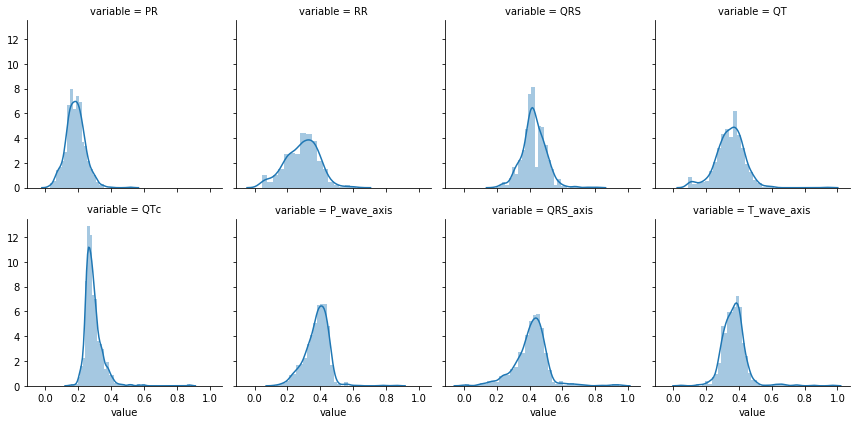

In [9]:
hlth_df_long = pd.melt(hlth_computation_df, value_vars=feature_names)
g = sns.FacetGrid(hlth_df_long, col="variable", col_wrap=4) 
g.map(sns.distplot, "value")

## Reduction of problematic data
I will present three aproaches to data:
1. Treat disiease not connected with heart or circulatory system (first letter of icd-10 code is not i) as control group so ill be thinking about them as healthy people and remove people with more than one disiease (they will make it harder for classifiers)
2. Do not consider theese diagnoses in experiment
3. Try to recognize every disiease evan if it is not connected with circulatory system (why the doctor outsorced ecg thest then? - maybe there is connection betweenc ecg and that disiease)

During avery approach i will present data distribution and try to teach couple of classifiers to test if the approach is sensible or not. Dataframes connected with every of theese aproaches will be marked by number of aproach so train_dataframe_1 means training data for first approach.

### Analising unmodified diagnosis_dataframe

In [10]:
print("length of dataframe: %d" %(len(diagnosis_df)))
print("Number of different people in unmodified diagnosis dataframe: %d" %(len(diagnosis_df["personid"].unique())))
print("Number of different disiease in unmodified diagnosis dataframe: %d" %(len(diagnosis_df["diagcode"].unique())))
print("Number of differend icd-10 classes in unmodigied diagnosis dataframe %d"
     %(len(pd.Series([i[0] for i in diagnosis_df["diagcode"].unique()]).unique())))
print("\n\nValue counts: ")
diagnosis_df["diagcode"].value_counts()[:10]

length of dataframe: 409291
Number of different people in unmodified diagnosis dataframe: 21197
Number of different disiease in unmodified diagnosis dataframe: 5759
Number of differend icd-10 classes in unmodigied diagnosis dataframe 25


Value counts: 


I10      13840
N18.9     7268
E11.9     6452
R07.4     6340
Z03.9     6257
I20.9     4394
E11.4     3945
C16.9     3444
K21.9     3269
C34.9     3212
Name: diagcode, dtype: int64

### Preparing dataframe to first approach
1. Remove patients with more than one diagnoses connected with circulatory system.
2. Remove patients with "Other and unspecified disorders of the circulatory system" and "Other forms of heart disease" becouse it is not connected with any specific disease.


#### Diagnosis dataframe

In [11]:
#Treat not "I" category as not connected with heart
diagnosis_df_1 = copy.copy(diagnosis_df)
diagnosis_df_1["diagcode"] = diagnosis_df["diagcode"].apply(reduceDiagnosis)

#Dataframe with only heart disieases in reduced dataframe to search for more than one disease
only_heart_df = diagnosis_df_1.loc[diagnosis_df_1["diagcode"] != "NoHeart"] #drop not heart diagnoses
only_heart_df = only_heart_df.loc[only_heart_df["diagcode"] != "OT"].drop_duplicates(subset=["personid", "diagcode"]) #drop other diagnoses
only_heart_df = (only_heart_df["personid"].value_counts() > 1)
only_heart_df = only_heart_df.loc[only_heart_df == True].index

#Dataframe with other deaseases of circulatory system
OH = diagnosis_df_1["diagcode"] == "OH"
OC = diagnosis_df_1["diagcode"] == "OC"
OT = [oh or oc for oh,oc in zip(OH,OC)]
other_df = diagnosis_df_1.loc[OT].drop_duplicates(subset = ["personid", "diagcode"])

print("People with other diagnosis: %d" %(len(other_df)))
print("People with more than one diagnosis: %d"%(len(only_heart_df)))

# Drop people with two diagoses connceted with heart and other diagnoses
diagnosis_df_1 = diagnosis_df_1.loc[diagnosis_df_1["personid"].isin(only_heart_df).apply(lambda x: not x)]
diagnosis_df_1 = diagnosis_df_1.loc[diagnosis_df_1["personid"].isin(other_df["personid"]).apply(lambda x: not x)]
diagnosis_df_1 = diagnosis_df_1.drop_duplicates(subset=["personid", "diagcode"]) #same diagnosis to same person

#Drop NoHeart when other diagnosis found
more_diag_df = (diagnosis_df_1["personid"].value_counts() > 1)
more_diag_df = more_diag_df.loc[more_diag_df == True].index
personid_list = diagnosis_df_1["personid"].isin(more_diag_df)
diagnosis_list = (diagnosis_df_1["diagcode"] == "NoHeart")
print("People with NoHeart and other diagnosis: %d" % (len(diagnosis_list)))
forloc = np.array([a and b for a,b in zip(personid_list, diagnosis_list)])
forloc = list((map(lambda x: not x, forloc)))
diagnosis_df_1 = diagnosis_df_1.loc[forloc]

#Leave only people with ECG test result
diagnosis_df_1 = diagnosis_df_1.loc[diagnosis_df_1["personid"].isin(ECG_df["personid"].unique())]

People with other diagnosis: 845
People with more than one diagnosis: 3331
People with NoHeart and other diagnosis: 17741


#### Analising simplified diagnosis_df_1

In [12]:
print("length of dataframe: %d" 
      %(len(diagnosis_df_1)))
print("Number of different people %d" 
      %(len(diagnosis_df_1["personid"].unique())))
print("Number of different disiease %d" 
      %(len(diagnosis_df_1["diagcode"].unique())))
print("Number of differend icd-10 classes %d"
     %(len(pd.Series([i[0] for i in diagnosis_df_1["diagcode"].unique()]).unique())))
print("\n\nValue counts: ")
diagnosis_df_1["diagcode"].value_counts()

length of dataframe: 14579
Number of different people 14579
Number of different disiease 9
Number of differend icd-10 classes 6


Value counts: 


Healthy    14139
CD           151
IH           106
HD           102
DV            49
DA            23
PH             7
AR             1
CR             1
Name: diagcode, dtype: int64

#### ECG_dataframe

In [13]:
ECG_df_1 = copy.copy(ECG_df)
ECG_df_1 = ECG_df_1.loc[ECG_df["personid"].isin(diagnosis_df_1["personid"])]

#### Connecting ECG results with diagnosis

In [14]:
computation_df_1 = ECG_df_1.merge(diagnosis_df_1, on="personid")[feature_names + ["diagcode"]]
computation_df_1 = computation_df_1.append(hlth_computation_df, sort=True)

### Preparing dataframe to second approach:
1. Remove all diagnoses with no "I" in icd-10 code

In [15]:
diagnosis_df_2 = copy.copy(diagnosis_df)
diagnosis_df_2["diagcode"] = diagnosis_df_2["diagcode"].apply(reduceDiagnosis)
diagnosis_df_2 = diagnosis_df_2.loc[diagnosis_df_2["diagcode"] != "Healthy"]
diagnosis_df_2 = diagnosis_df_2.loc[diagnosis_df_2["personid"].isin(ECG_df["personid"].unique())]
diagnosis_df_2 = diagnosis_df_2.drop_duplicates(subset = ["personid", "diagcode"])

In [16]:
ECG_df_2 = copy.copy(ECG_df)
ECG_df_2 = ECG_df_2.loc[ECG_df_2["personid"].isin(diagnosis_df_2["personid"].unique())]
computation_df_2 = ECG_df_2.merge(diagnosis_df_2, on="personid")[feature_names + ["diagcode"]]
computation_df_2 = computation_df_2.append(hlth_computation_df, sort=True)

In [17]:
print("length of dataframe: %d" 
      %(len(diagnosis_df_2)))
print("Number of different people %d" 
      %(len(diagnosis_df_2["personid"].unique())))
print("Number of different disiease %d" 
      %(len(diagnosis_df_2["diagcode"].unique())))
print("Number of differend icd-10 classes %d"
     %(len(pd.Series([i[0] for i in diagnosis_df_2["diagcode"].unique()]).unique())))
print("\n\nValue counts: ")
diagnosis_df_2["diagcode"].value_counts()

length of dataframe: 4834
Number of different people 3566
Number of different disiease 10
Number of differend icd-10 classes 7


Value counts: 


HD    1712
IH     747
CD     664
OH     596
PH     375
DV     351
DA     227
OC      96
CR      55
AR      11
Name: diagcode, dtype: int64

### Preparing dataframe to third approach:

In [18]:
diagnosis_df_3 = copy.copy(diagnosis_df)
diagnosis_df_3 = diagnosis_df_3.loc[diagnosis_df_3["personid"].isin(ECG_df["personid"].unique())]

In [19]:
ECG_df_3 = copy.copy(ECG_df)
ECG_df_3 = ECG_df_3.loc[ECG_df_3["personid"].isin(diagnosis_df_3["personid"].unique())]
computation_df_3 = ECG_df_3.merge(diagnosis_df_3, on="personid")[feature_names + ["diagcode"]]
computation_df_3 = computation_df_3.append(hlth_computation_df, sort=True)

In [20]:
print("length of dataframe: %d" 
      %(len(diagnosis_df_3)))
print("Number of different people %d" 
      %(len(diagnosis_df_3["personid"].unique())))
print("Number of different disiease %d" 
      %(len(diagnosis_df_3["diagcode"].unique())))
print("Number of differend icd-10 classes %d"
     %(len(pd.Series([i[0] for i in diagnosis_df_3["diagcode"].unique()]).unique())))
print("\n\nValue counts: ")
diagnosis_df_3["diagcode"].value_counts()

length of dataframe: 385233
Number of different people 17705
Number of different disiease 5586
Number of differend icd-10 classes 25


Value counts: 


I10      13116
N18.9     7229
R07.4     6209
E11.9     6162
I20.9     4301
         ...  
F92.9        1
T59.5        1
I77.9        1
S23.5        1
D01.4        1
Name: diagcode, Length: 5586, dtype: int64

C:\Users\Dawid.Wieclaw\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Dawid.Wieclaw\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


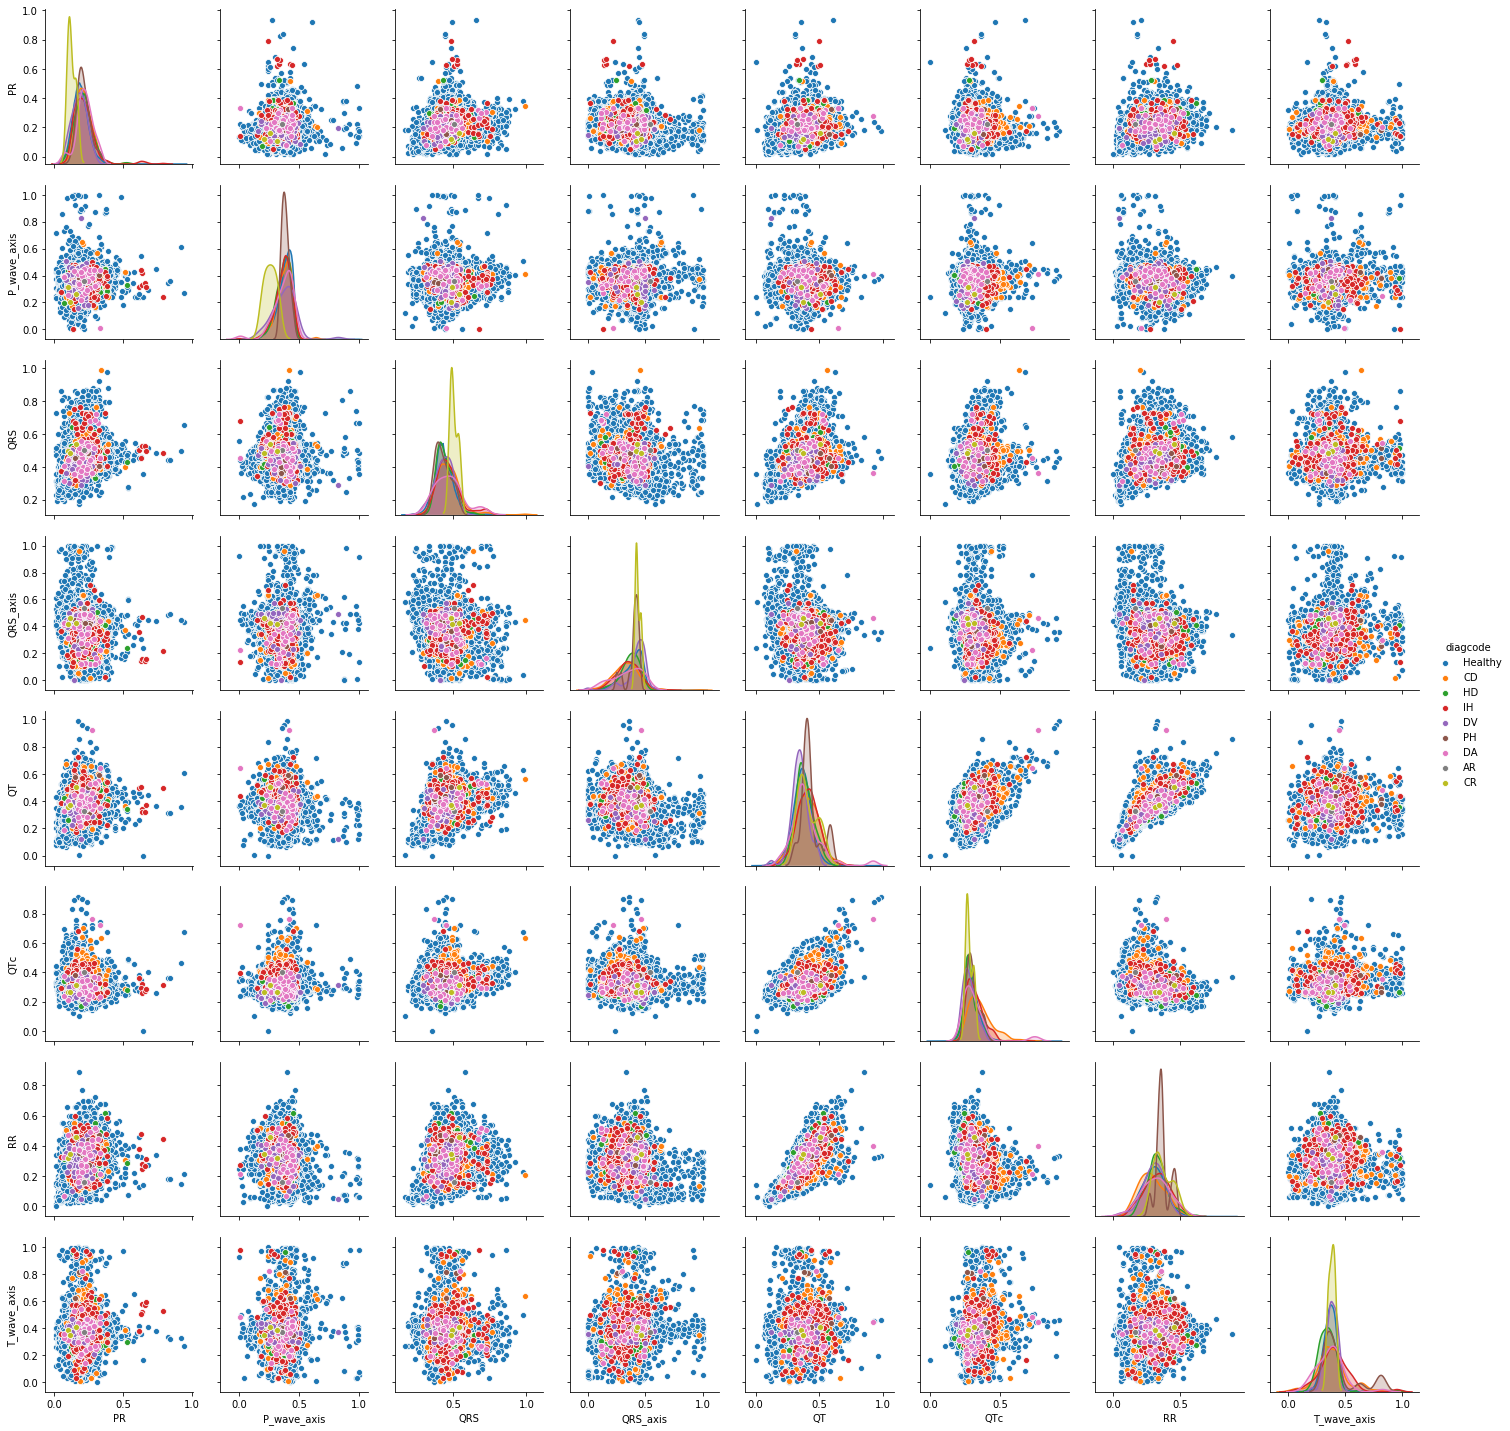

In [21]:
#First approach data distribution
#too many healthy people
sns.pairplot(computation_df_1, hue="diagcode")

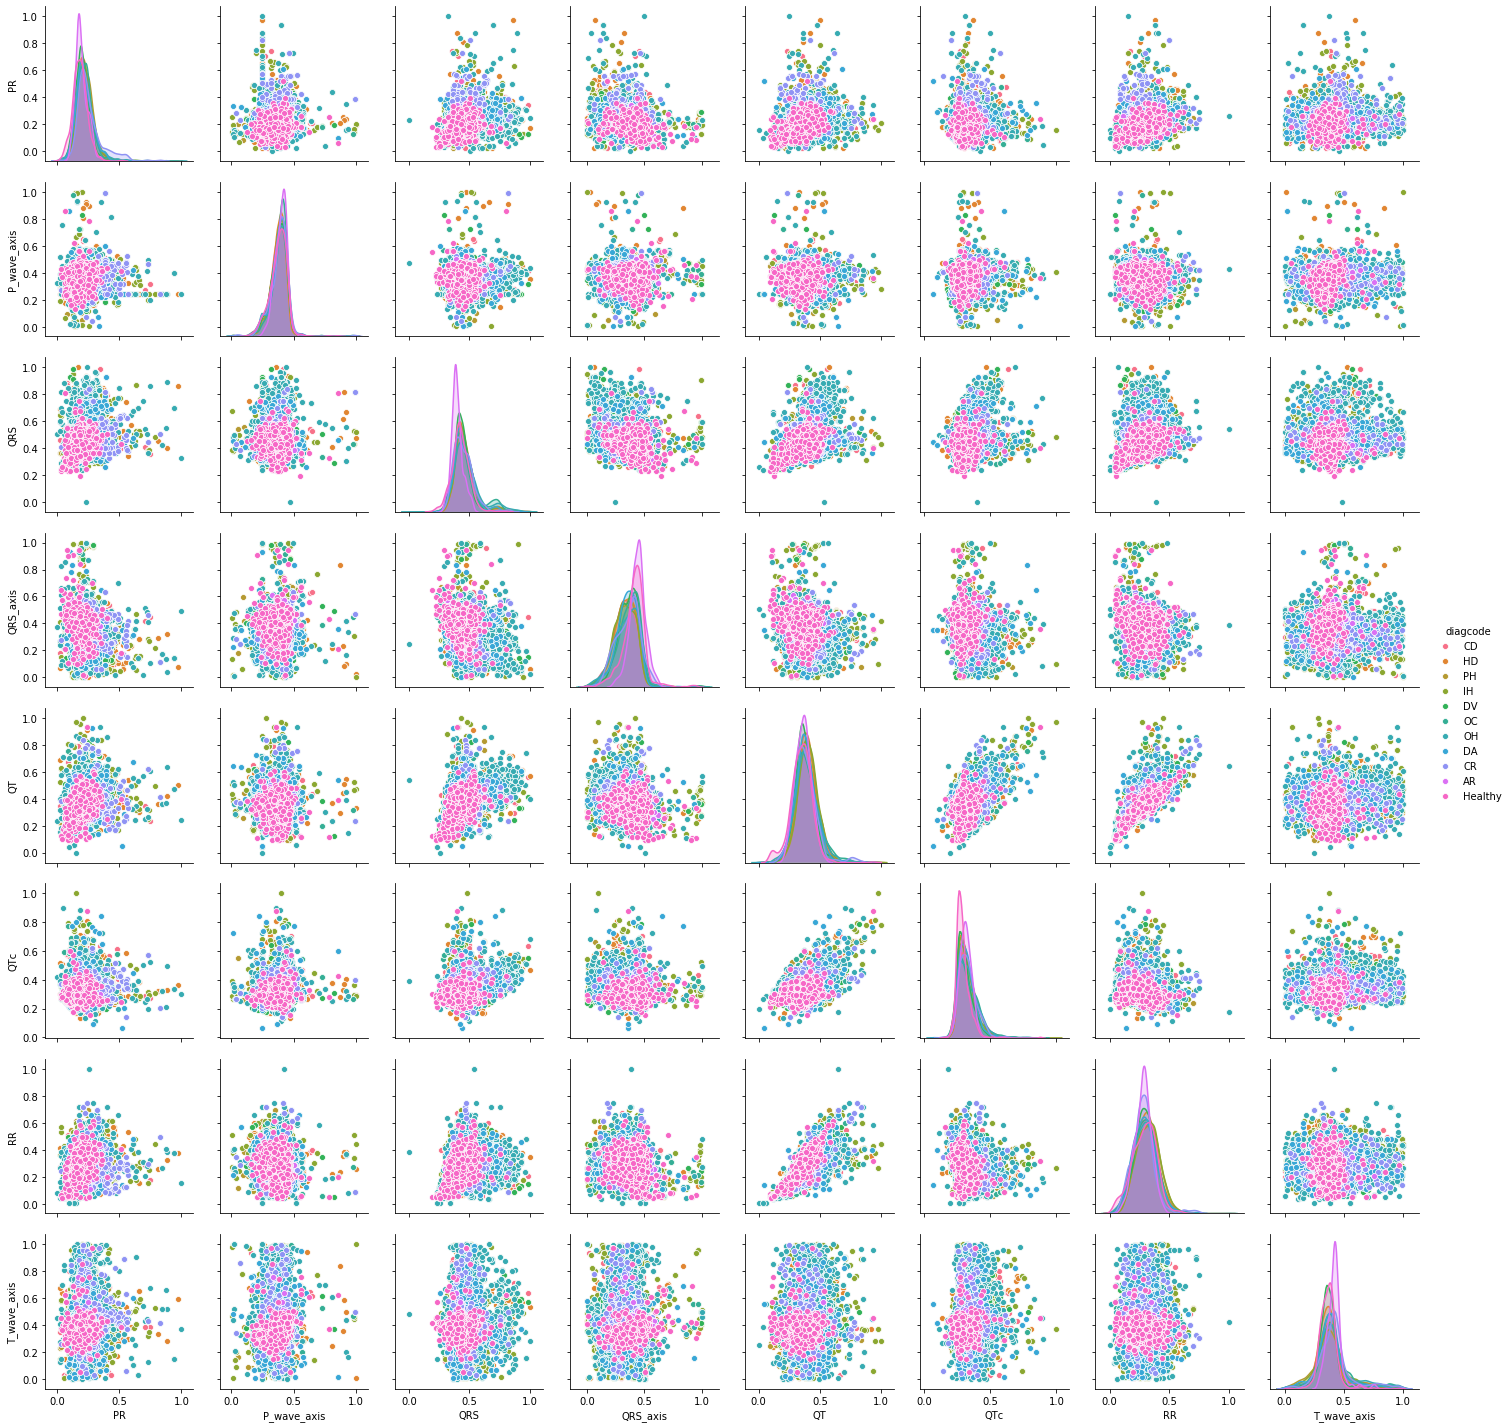

In [22]:
#second approach data distribution
sns.pairplot(computation_df_2, hue="diagcode")

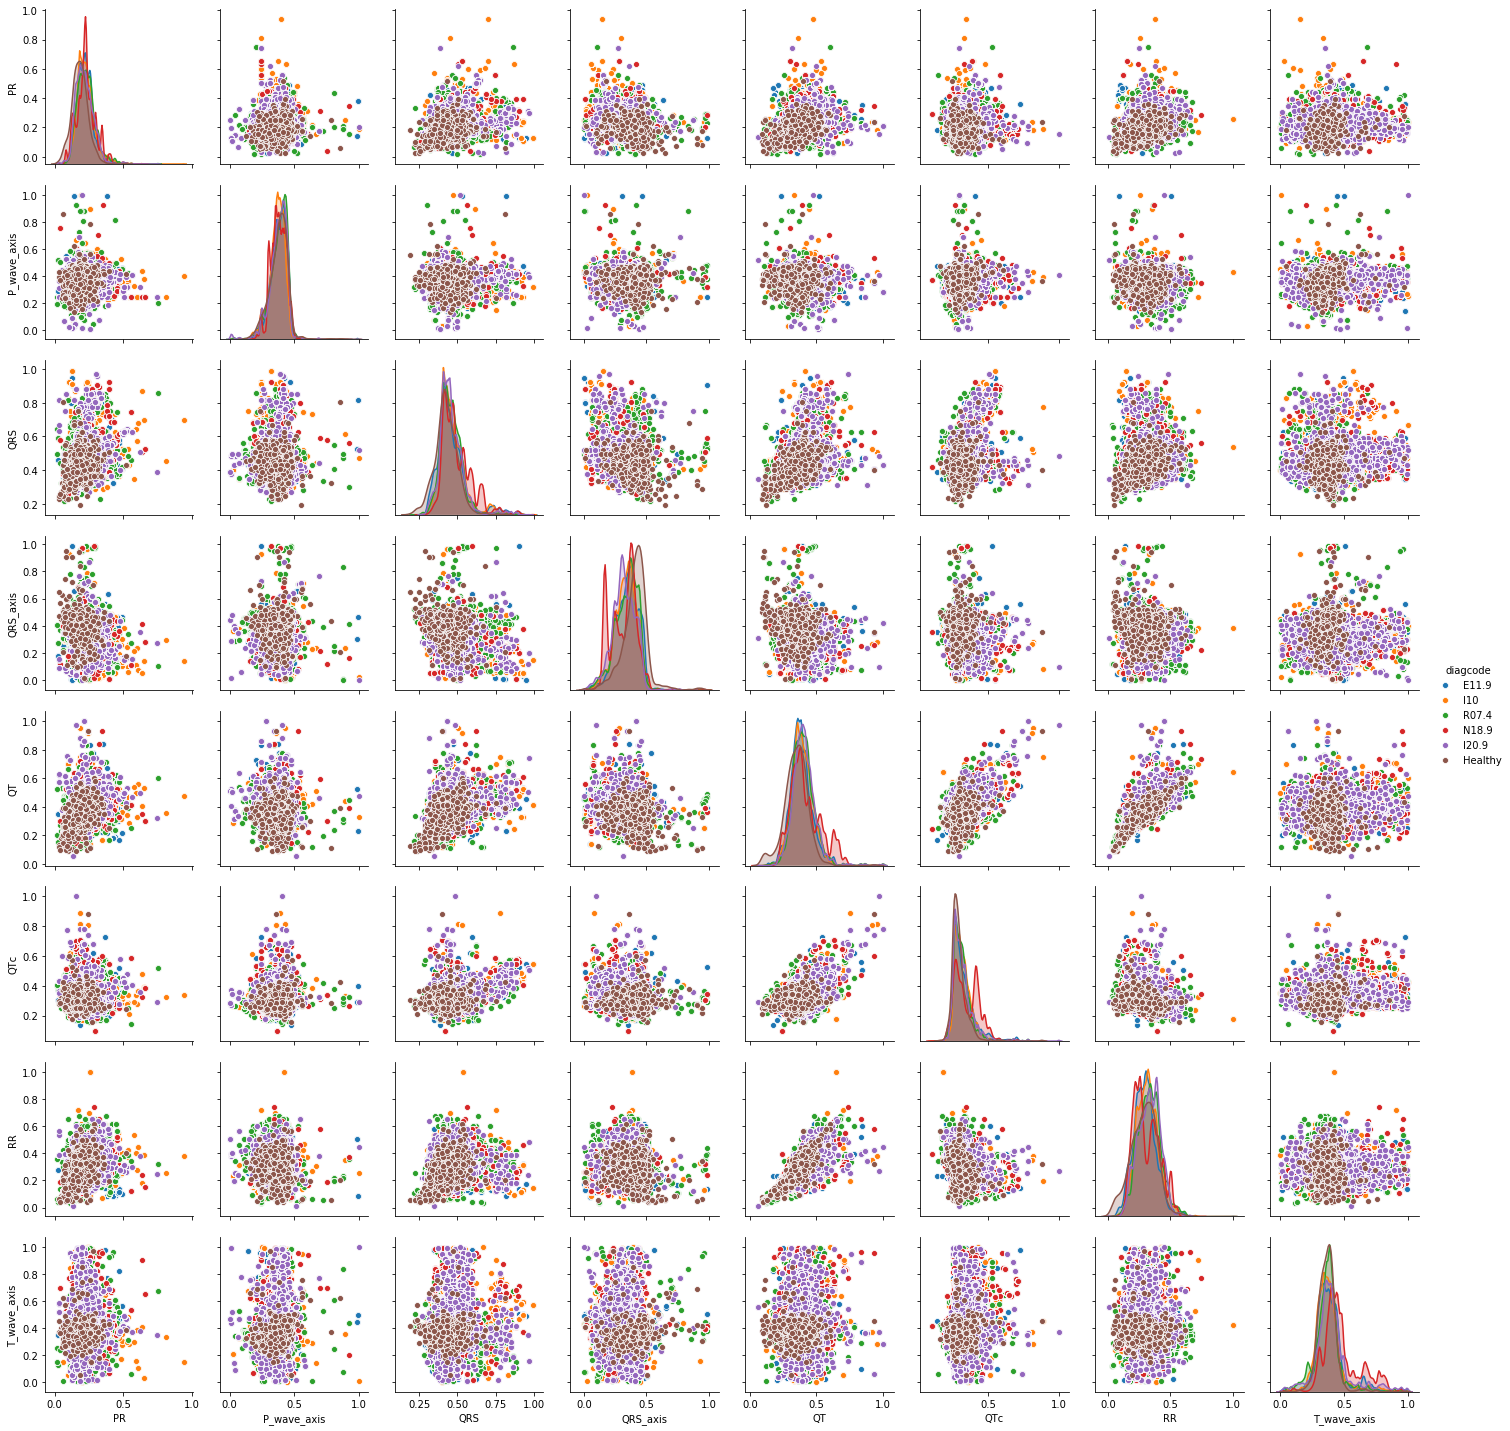

In [23]:
#third approach data distribution
#there are too many disieases so I will show only 5 most common
most_common_df = computation_df_3["diagcode"].value_counts()>32000
disieases = list(most_common_df.loc[most_common_df == True].index.unique())
if not "Healthy" in disieases:
    disieases.append("Healthy")
vis_df_3 = computation_df_3.loc[computation_df_3["diagcode"].isin(disieases)]
sns.pairplot(vis_df_3, hue="diagcode") 

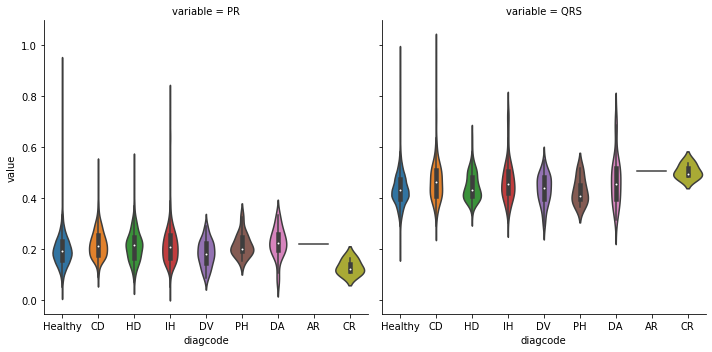

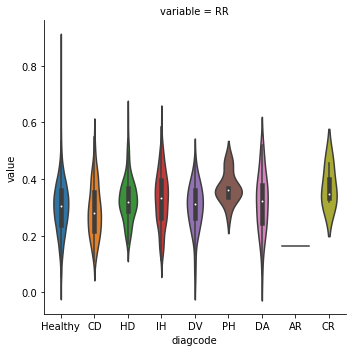

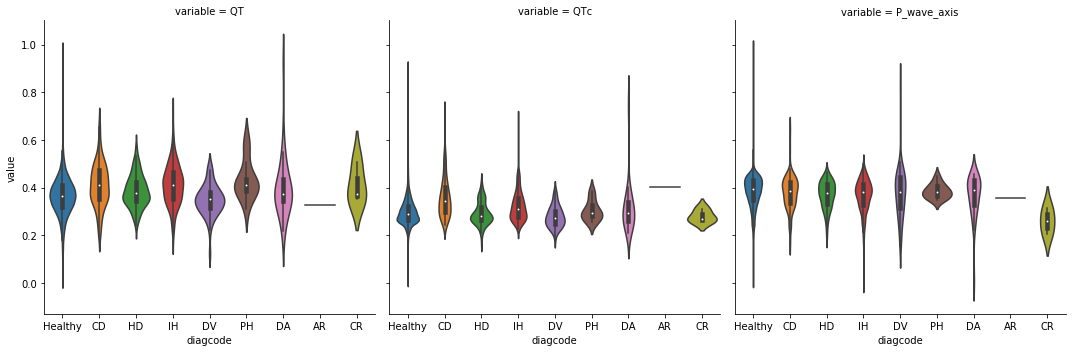

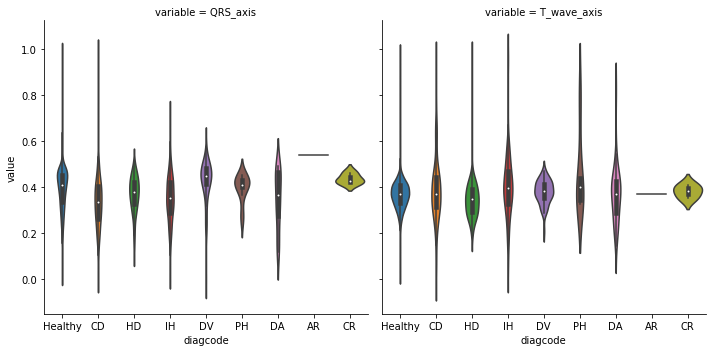

In [24]:
computation_df_long = computation_df_1.loc[computation_df_1["diagcode"].isin(diagnosis_names_short)]
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[0:3:2])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")
computation_df_long = computation_df_1.loc[computation_df_1["diagcode"].isin(diagnosis_names_short)]
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[1])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")
computation_df_long = computation_df_1.loc[computation_df_1["diagcode"].isin(diagnosis_names_short)]
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[3:6])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")
computation_df_long = computation_df_1.loc[computation_df_1["diagcode"].isin(diagnosis_names_short)]
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[6:9])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")

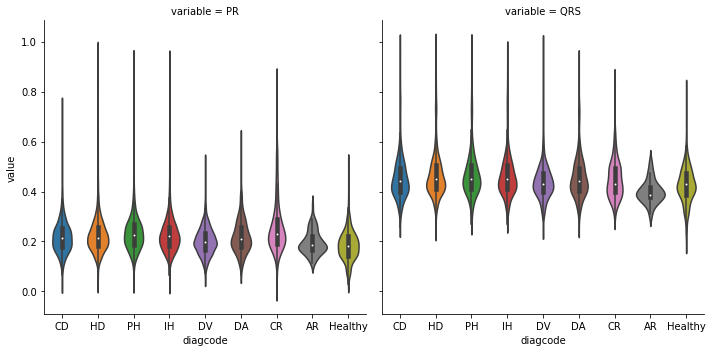

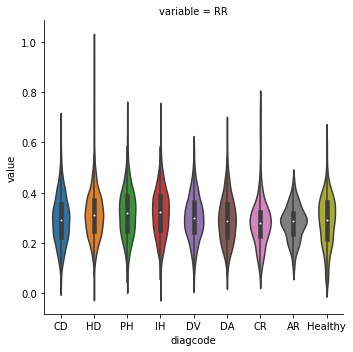

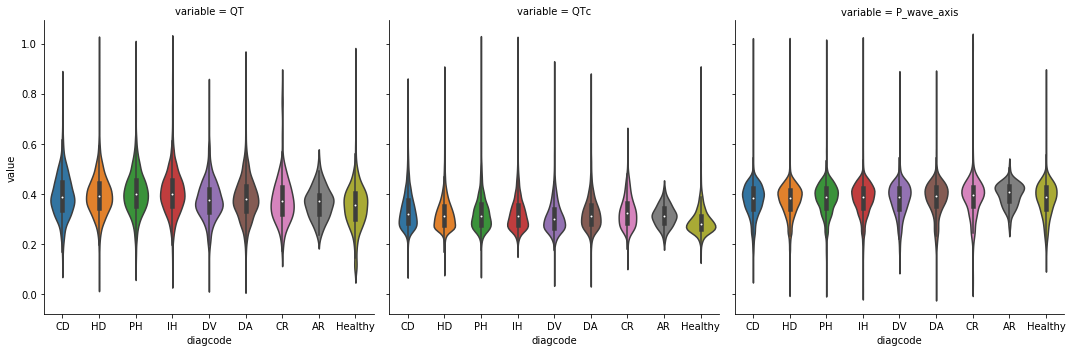

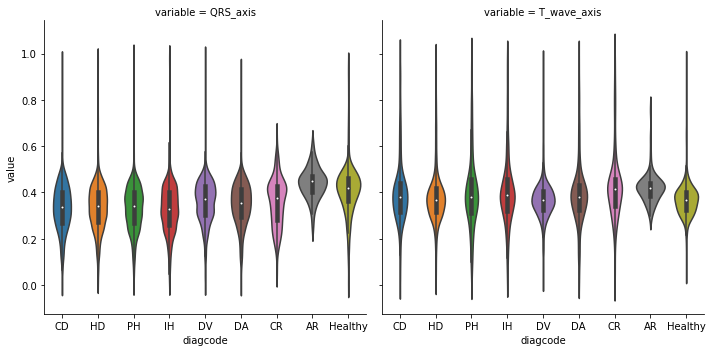

In [25]:
computation_df_long = computation_df_2.loc[computation_df_2["diagcode"].isin(diagnosis_names_short)]
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[0:3:2])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")
computation_df_long = computation_df_2.loc[computation_df_2["diagcode"].isin(diagnosis_names_short)]
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[1])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")
computation_df_long = computation_df_2.loc[computation_df_2["diagcode"].isin(diagnosis_names_short)]
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[3:6])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")
computation_df_long = computation_df_2.loc[computation_df_2["diagcode"].isin(diagnosis_names_short)]
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[6:9])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")

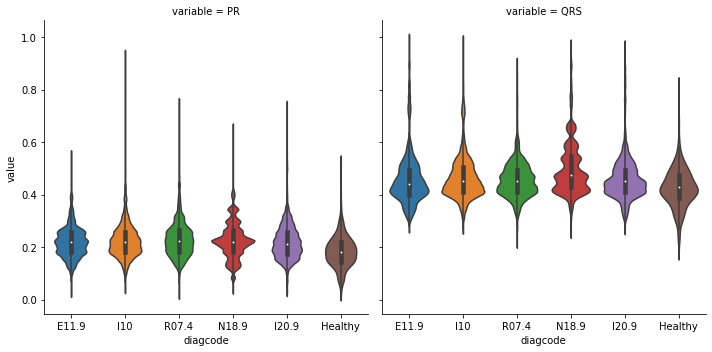

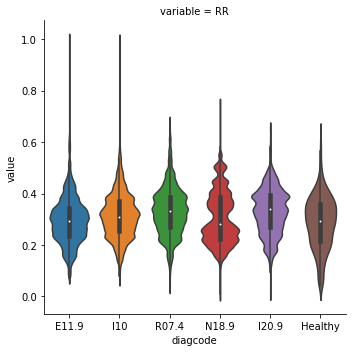

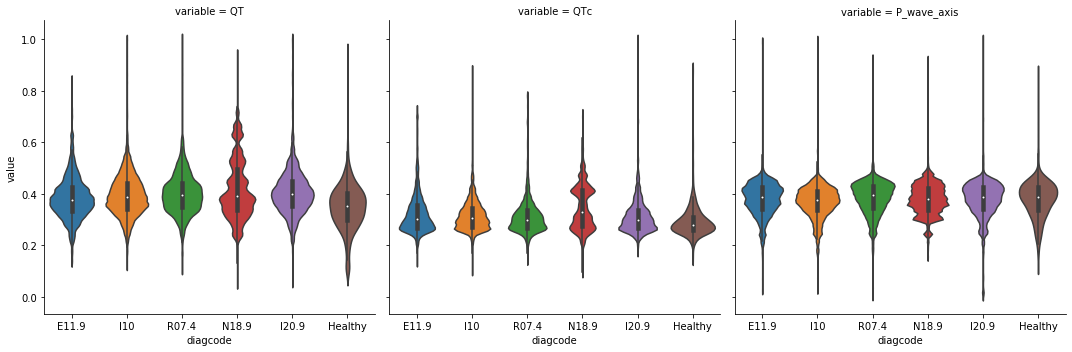

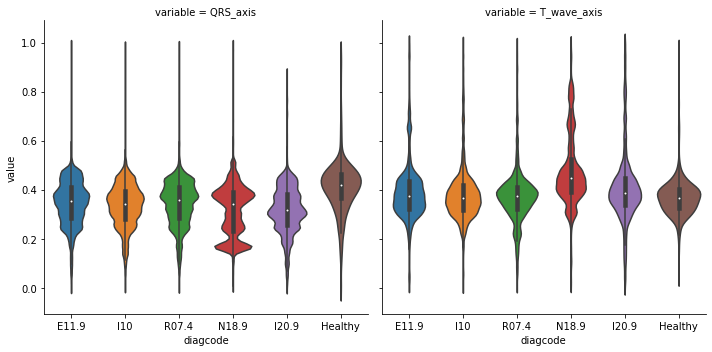

In [26]:
computation_df_long = vis_df_3
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[0:3:2])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")
computation_df_long = vis_df_3
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[1])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")
computation_df_long = vis_df_3
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[3:6])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")
computation_df_long = vis_df_3
computation_df_long = pd.melt(computation_df_long, id_vars=['diagcode'], value_vars=feature_names[6:9])
sns.catplot(x='diagcode',y='value',col='variable',data=computation_df_long, kind="violin")

## Preparation for training classifiers

In [65]:
msk = np.random.rand(len(computation_df_1)) < 0.8
train_df_1 = computation_df_1[msk]
test_df_1 = computation_df_1[~msk]

msk = np.random.rand(len(computation_df_2)) < 0.8
train_df_2 = computation_df_2[msk]
test_df_2 = computation_df_2[~msk]

msk = np.random.rand(len(computation_df_3)) < 0.8
train_df_3 = computation_df_3[msk]
test_df_3 = computation_df_3[~msk]

## Preparing reduced datasets to show result of classifiers on 2d grid

In [66]:
pca = PCA(n_components = 2)
principal = pca.fit_transform(computation_df_1[feature_names])
msk = np.random.rand(len(computation_df_1)) < 0.8
reduced_train_data_1 = principal[msk]
reduced_train_label_1 = computation_df_1[msk]["diagcode"]
reduced_test_data_1 = principal[~msk]
reduced_test_label_1 = computation_df_1[~msk]["diagcode"]

pca = PCA(n_components = 2)
principal = pca.fit_transform(computation_df_2[feature_names])
msk = np.random.rand(len(computation_df_2)) < 0.8
reduced_train_data_2 = principal[msk]
reduced_train_label_2 = computation_df_2[msk]["diagcode"]
reduced_test_data_2 = principal[~msk]
reduced_test_label_2 = computation_df_2[~msk]["diagcode"]


pca = PCA(n_components = 2)
principal = pca.fit_transform(computation_df_3[feature_names])
msk = np.random.rand(len(computation_df_3)) < 0.8
reduced_train_data_3 = principal[msk]
reduced_train_label_3 = computation_df_3[msk]["diagcode"]
reduced_test_data_3 = principal[~msk]
reduced_test_label_3 = computation_df_3[~msk]["diagcode"]

## KNN algorithm
First method I use to show how data is resitive to classifying

In [67]:
def testWithKNN(train_df, test_df, ks):
    best_params = []
    best_accuracy = 0.0
    i = 0
    for k in ks:
        clf = KNeighborsClassifier(n_neighbors = k, n_jobs=24)
        clf.fit(train_df[feature_names], train_df["diagcode"])
        preds = clf.predict(test_df[feature_names])
        accuracy = np.mean(preds == test_df["diagcode"])
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
    print("best_k: %d" %(best_k))
    print("best accuracy: %f" % (best_accuracy))

In [30]:
#Computation on reduced dataset to find best params for visualisation
print("Results for 1st dataset:")
testWithKNN(train_df_1, test_df_1, range(1, 100, 2))
print("Results for 2nd dataset:")
testWithKNN(train_df_2, test_df_2, range(1, 100, 2))
print("Results for 3rd dataset:")
testWithKNN(train_df_3, test_df_3, range(1, 100, 2))

Results for 1st dataset:
best_k: 7
best accuracy: 0.972368
Results for 2nd dataset:
best_k: 75
best accuracy: 0.308238
Results for 3rd dataset:
best_k: 31
best accuracy: 0.282400


It seems that it works quite nice on first dataset but it is so becouse first dataset is almost only made of healthy results and we have seen its distribution that does not contain only healthy results.

In [24]:
print("healthy/all = %f" % (computation_df_1["diagcode"].value_counts()["Healthy"]/len(computation_df_1)))

healthy/all = 0.968767


In [32]:
#search for best k in reduced datasets
best_k = 0
best_accuracy = 0.0
i = 0
for k in range(1, 100, 4):
    clf = KNeighborsClassifier(n_neighbors = k, n_jobs=24)
    
    clf.fit(reduced_train_data_1, reduced_train_label_1)
    preds = clf.predict(reduced_test_data_1)
    accuracy = np.mean(preds == reduced_test_label_1)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
best_k_1 = best_k
print("best accuracy: %f" % (best_accuracy))

best accuracy: 0.974553


In [33]:
#search for best k in reduced datasets
best_k = 0
best_accuracy = 0.0
i = 0
for k in range(1, 100, 4):
    clf = KNeighborsClassifier(n_neighbors = k, n_jobs=24)
    
    clf.fit(reduced_train_data_2, reduced_train_label_2)
    preds = clf.predict(reduced_test_data_2)
    accuracy = np.mean(preds == reduced_test_label_2)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
print("best accuracy: %f" % (best_accuracy))
best_k_2 = best_k

best accuracy: 0.314106


In [34]:
#search for best k in reduced datasets
best_k =0
best_accuracy = 0.0
i = 0
for k in range(1, 100, 4):
    clf = KNeighborsClassifier(n_neighbors = k, n_jobs=24)
    
    clf.fit(reduced_train_data_3, reduced_train_label_3)
    preds = clf.predict(reduced_test_data_3)
    accuracy = np.mean(preds == reduced_test_label_3)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
        print(best_accuracy)
print("best accuracy: %f" % (best_accuracy))
best_k_3 = best_k

0.2464732426859546
0.27175896015426393
0.27720720921424913
0.27922214548631996
0.2803162509313511
0.28045487062574415
0.280927662797692
0.28127668738536027
best accuracy: 0.281277


## Visualisation of work of KNN classifiers on reduced by pca data

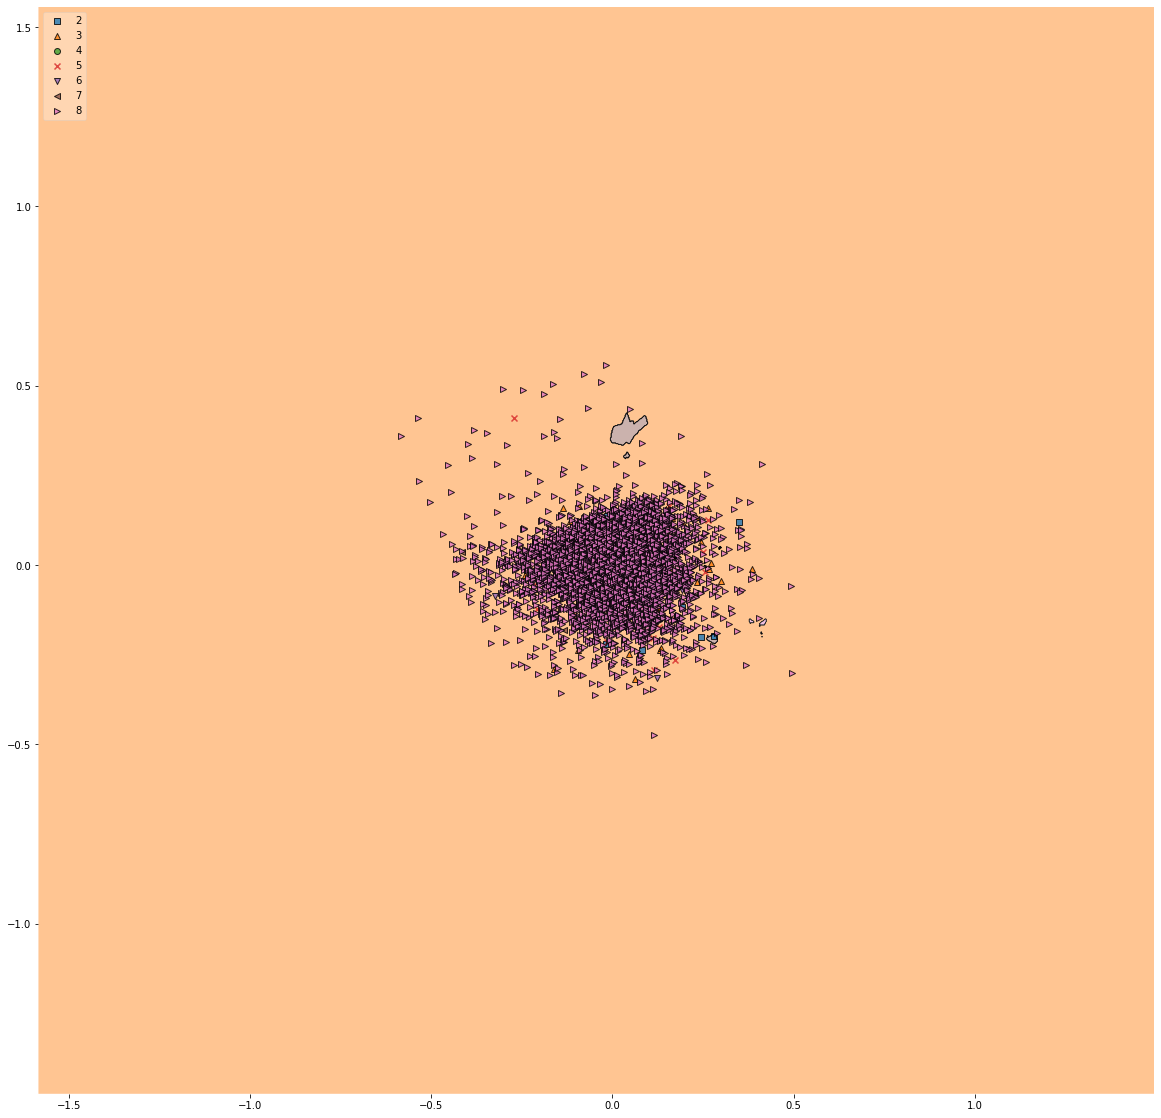

In [35]:
clf = KNeighborsClassifier(n_neighbors = best_k_1, n_jobs=24)
clf.fit(reduced_train_data_1, reduced_train_label_1.apply(toNumbers).to_numpy().astype(np.integer))
plt.figure(figsize=(20,20))
plot_decision_regions(reduced_test_data_1, 
                      reduced_test_label_1.apply(toNumbers).to_numpy().astype(np.integer), 
                      clf=clf, legend=2)

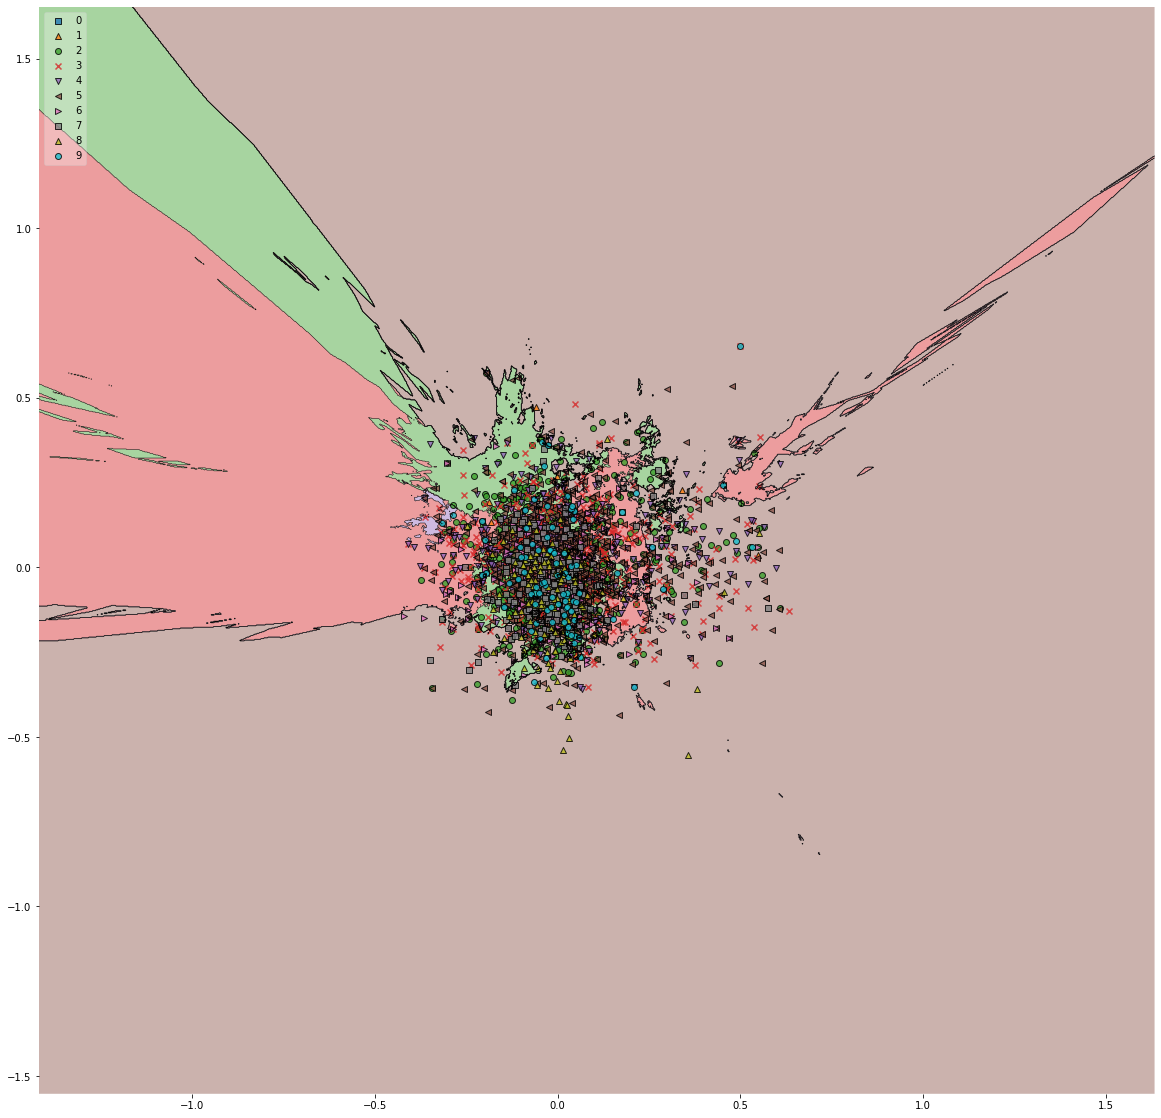

In [36]:
clf = KNeighborsClassifier(n_neighbors = best_k_2, n_jobs=24)
clf.fit(reduced_train_data_2, reduced_train_label_2.apply(toNumbers).to_numpy().astype(np.integer))
plt.figure(figsize=(20,20))
plot_decision_regions(reduced_test_data_2, 
                      reduced_test_label_2.apply(toNumbers).to_numpy().astype(np.integer), 
                      clf=clf, legend=2)

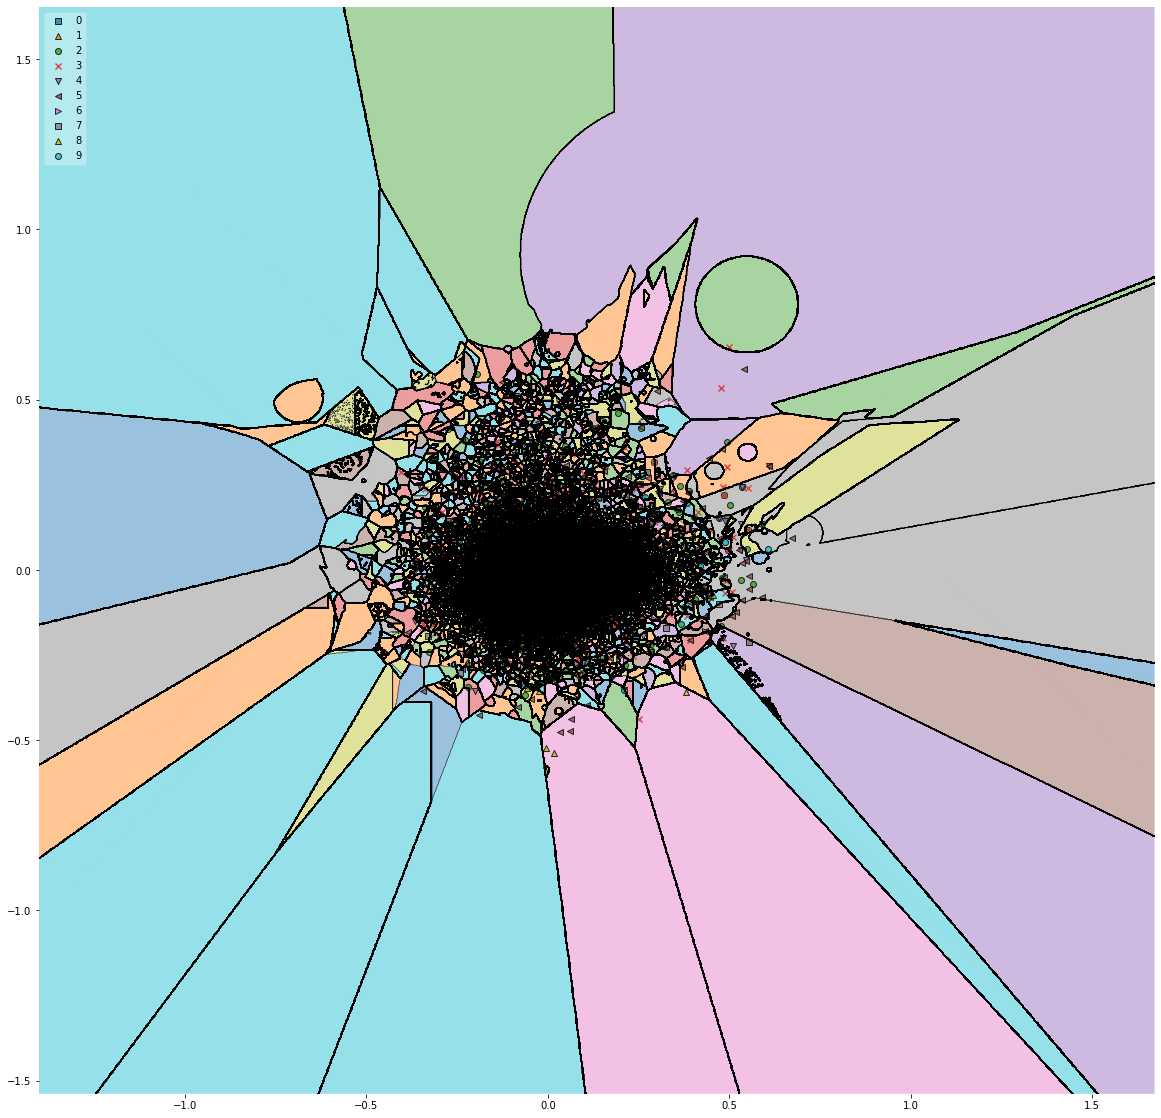

In [41]:
diagcodes = computation_df_3["diagcode"].unique() 
clf = KNeighborsClassifier(n_neighbors = best_k_3, n_jobs=48, weights="distance", algorithm="kd_tree")
clf.fit(reduced_train_data_3, reduced_train_label_3.apply(lambda x: np.where(diagcodes == x)[0][0]).to_numpy().astype(np.integer))
plt.figure(figsize=(20,20))
plot_decision_regions(reduced_test_data_2, 
                      reduced_test_label_2.apply(toNumbers).to_numpy().astype(np.integer), 
                      clf=clf, legend=2)

## Conclusion from first attempt to classify
First classification attempt showed, that the best dataset is the third one, because it is the most real and tricks applied to dataset didn't help because it made dataset contain almost only one class. Second approach gave dataset that was even harder to predict on than third one. That is why further computation will be applied only to train_df_3. Because of using only ECG data there is a need to study most common diseases that appeared in that dataframe. Most common diseases in train_df_3 are:

In [68]:
computation_df_3["diagcode"].value_counts()[:20]

N18        98311
I20        63979
Healthy    40542
I25        28214
I21        23456
J45        22058
M81        20778
N40        20108
C34        19691
I10        16863
I63        15552
H36        15434
N95        14330
F32        14094
M54        14078
M51        13802
J44        13467
J18        12707
M25        11858
F41        10350
Name: diagcode, dtype: int64

## Most common diseases description:
1. I10 - Essential (primary) hypertension it is not strongly connected to ecg measure (only consequences can be seen in ecg)
2. N18.9 - Chronic Kidney Disease - according to https://www.ncbi.nlm.nih.gov/pubmed/28712176 we can conclude that it can be detected by ecg abnormalities
3. E11.9 - According to https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5449835/ the connection between ecg and type Type 2 Diabetes Mellitus is weak
4. I20.9 - angina pectoris - Accordin to https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5051487/ ecg is useful in detection such disease
5. R07.4 - chest pain - very hard to detect becouse can be caused by many factors
6. E11.4 - same as E11.9
7. N18.0 - same as N18.9
8. C16.9 - Lintistic plastica - according to https://gut.bmj.com/content/gutjnl/9/4/485.full.pdf ecg results were normal
9. I20.0 - Unstable angina - according to https://www.healio.com/cardiology/learn-the-heart/cardiology-review/topic-reviews/coronary-artery-disease-unstable-anginanstemi it can be detected with ecg
10. K21.9 - gastroesophageal reflux disease - it can be symptom of infarct but does not have to so cant classify theese results as normal or as abnormal
11. I21.9 - Acute myocardial infarction - can be detected using ECG
12. E78.5 - Hyperlipidemia - according to https://www.ncbi.nlm.nih.gov/pubmed/16107907 it causes ecg abnormalities
13. C34.9 - Malignant neoplasm of unspecified part of bronchus or lung - causes ecg abnormality 
14. E11.3 - Type 2 diabetes mellitus - same as E11.9
15. C20 - Malignant neoplasm of rectum - according to https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4076711/ ecg is used to facilitatte judgement
16. N40 - Benign prostatic hyperplasia - not connected with ecg
17. Z03.9 - Doesn't provide any specific ecg abnormalities
18. K25.9 - Gastric ulcer - must perforate
19. E11.2 - same as E11.9
20. N18.5CA - same as N18.9


As a conclusion from theese description reducing number of categories by cutting number after "." is safe because symptoms for one such group are the same. From this research I can also conclude that eliminating disieases that give very simmilar results to Healthy can be good idea becouse I classify only by ecg.

# Improving dataset - first try
Removing diseases that corelation with ECG is uncertain and swapping diseases that will give healthy ECG to Healthy class

In [22]:
#First reduction
Esym = list(filter(lambda x: x[0] != "E", computation_df_3["diagcode"]))
Ksym = list(filter(lambda x: x[0] != "K", computation_df_3["diagcode"]))
Rsym = list(filter(lambda x: x[0] != "R" or x[1] == "0", computation_df_3["diagcode"]))
Csym = list(filter(lambda x: x[0] != "C" or x=="C34.9", computation_df_3["diagcode"]))

normal = ["Z03.9", "C16.9"]

In [23]:
def swap_to_normal(x):
    if x in normal:
        return "Healthy"
    return x

In [24]:
computation_df_3 = computation_df_3.loc[computation_df_3["diagcode"].isin(Esym)]
computation_df_3 = computation_df_3.loc[computation_df_3["diagcode"].isin(Ksym)]
computation_df_3 = computation_df_3.loc[computation_df_3["diagcode"].isin(Rsym)]
computation_df_3 = computation_df_3.loc[computation_df_3["diagcode"] != "I10"]
computation_df_3 = computation_df_3.loc[computation_df_3["diagcode"] != "R07.4"]
computation_df_3["diagcode"] = computation_df_3["diagcode"].apply(swap_to_normal)
computation_df_3 = computation_df_3.loc[computation_df_3["diagcode"].isin(Csym)]

In [25]:
computation_df_3["diagcode"] = computation_df_3["diagcode"].apply(lambda x: x.split(".")[0])

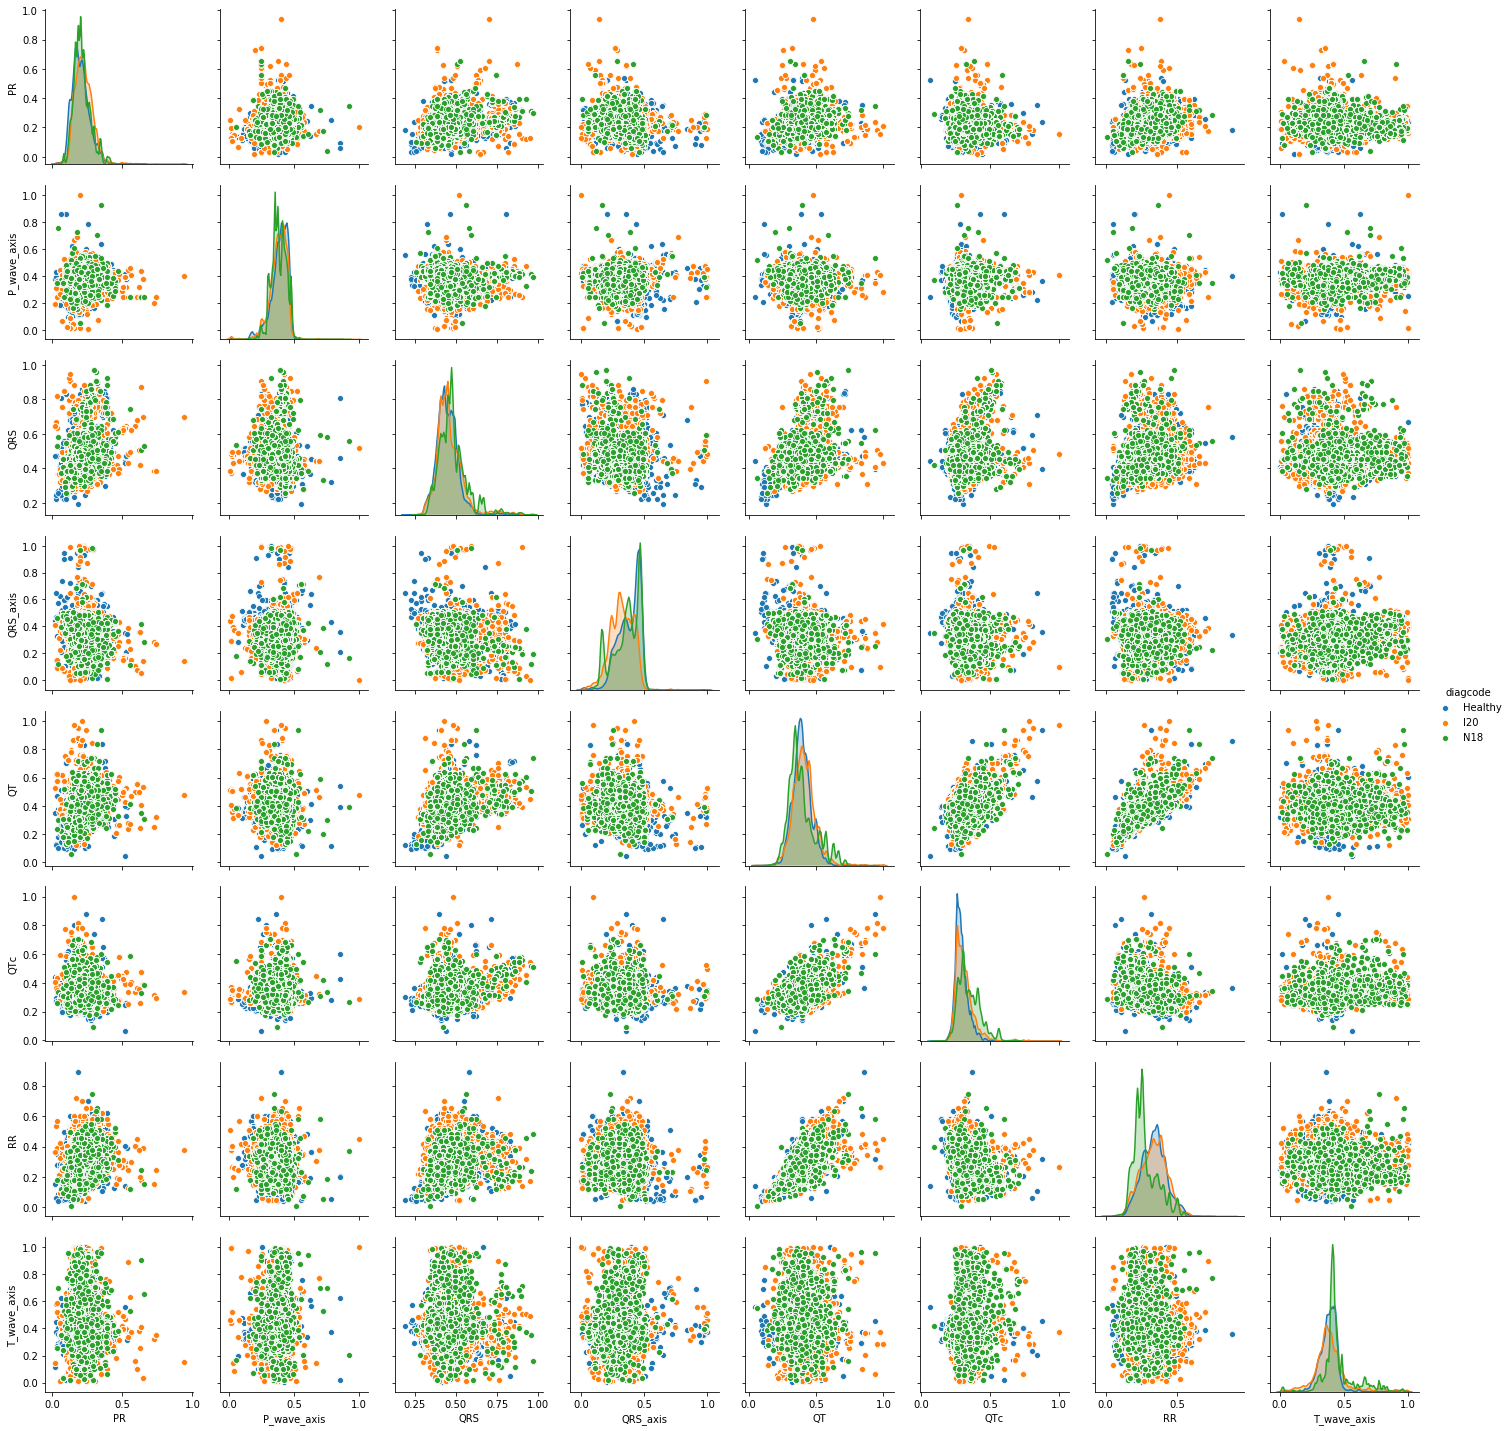

In [29]:
#there are too many disieases so I will show only most common
most_common_df = computation_df_3["diagcode"].value_counts()>32000
disieases = list(most_common_df.loc[most_common_df == True].index.unique())
if not "Healthy" in disieases:
    disieases.append("Healthy")
vis_df_3 = computation_df_3.loc[computation_df_3["diagcode"].isin(disieases)]
sns.pairplot(vis_df_3, hue="diagcode") 

In [69]:
msk = np.random.rand(len(computation_df_3)) < 0.8
train_df_3 = computation_df_3[msk]
test_df_3 = computation_df_3[~msk]

In [70]:
testWithKNN(train_df_3, test_df_3, range(1,100,20))

best_k: 21
best accuracy: 0.406702


As we can see there is a big improvment in algorithm working so i will asume that it is ok for further computation

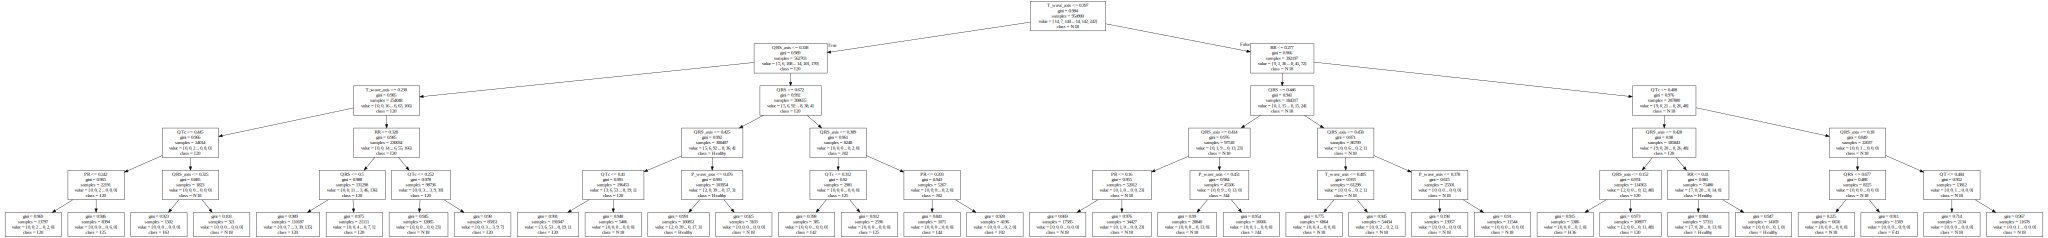

In [32]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(train_df_3[feature_names], train_df_3["diagcode"])
treeVis = tree.export_graphviz(clf, feature_names=feature_names, class_names = clf.classes_)
graphviz.Source(treeVis)

## More of data improvment
There are too many classes in considered dataframe, some of them give simmilar results to healthy class so they must be removed.

In [26]:
#removing classes that have too few examples in datafame
toRemove = set()
arr = (computation_df_3["diagcode"].value_counts() < 50)
for diag in computation_df_3["diagcode"].unique():
    if arr[diag]:
        toRemove.add(diag)

In [27]:
computation_df_3 = computation_df_3.loc[computation_df_3["diagcode"].isin(toRemove).apply(lambda x : not x)]

In [ ]:
print("Number of different diagnoses: %d" % (len(computation_df_3["diagcode"].unique())))

In [29]:
classes = computation_df_3["diagcode"].unique()
classes = np.delete(classes, np.where(classes == "Healthy")[0][0])

In [30]:
healthy_df = computation_df_3.loc[computation_df_3["diagcode"] == "Healthy"]
healthy_mean = healthy_df.mean()

In [31]:
most_differing = set()
for diag in classes:
    if diag == "Healthy": print("problem")
    diag_df = computation_df_3.loc[computation_df_3["diagcode"] == diag]
    diag_mean = diag_df.mean()
    dif_measure = np.sum(np.square(healthy_mean - diag_mean))
    most_differing.add((-dif_measure, diag))

best_diseases = [x[1] for x in sorted(most_differing)[:200]]

### Check if Google was right about abnormalities in diseases described above

In [32]:
print("N18" in best_diseases)
print("I20" in best_diseases)
print("I21" in best_diseases)
print("E78" in best_diseases)
print("C34" in best_diseases)

False
False
False
False
False


In [35]:
suspected_diseases = []
suspected_diseases.append("N18")
suspected_diseases.append("I20")
suspected_diseases.append("I21")
suspected_diseases.append("E78")
suspected_diseases.append("C34")
suspected_diseases.append("Healthy")

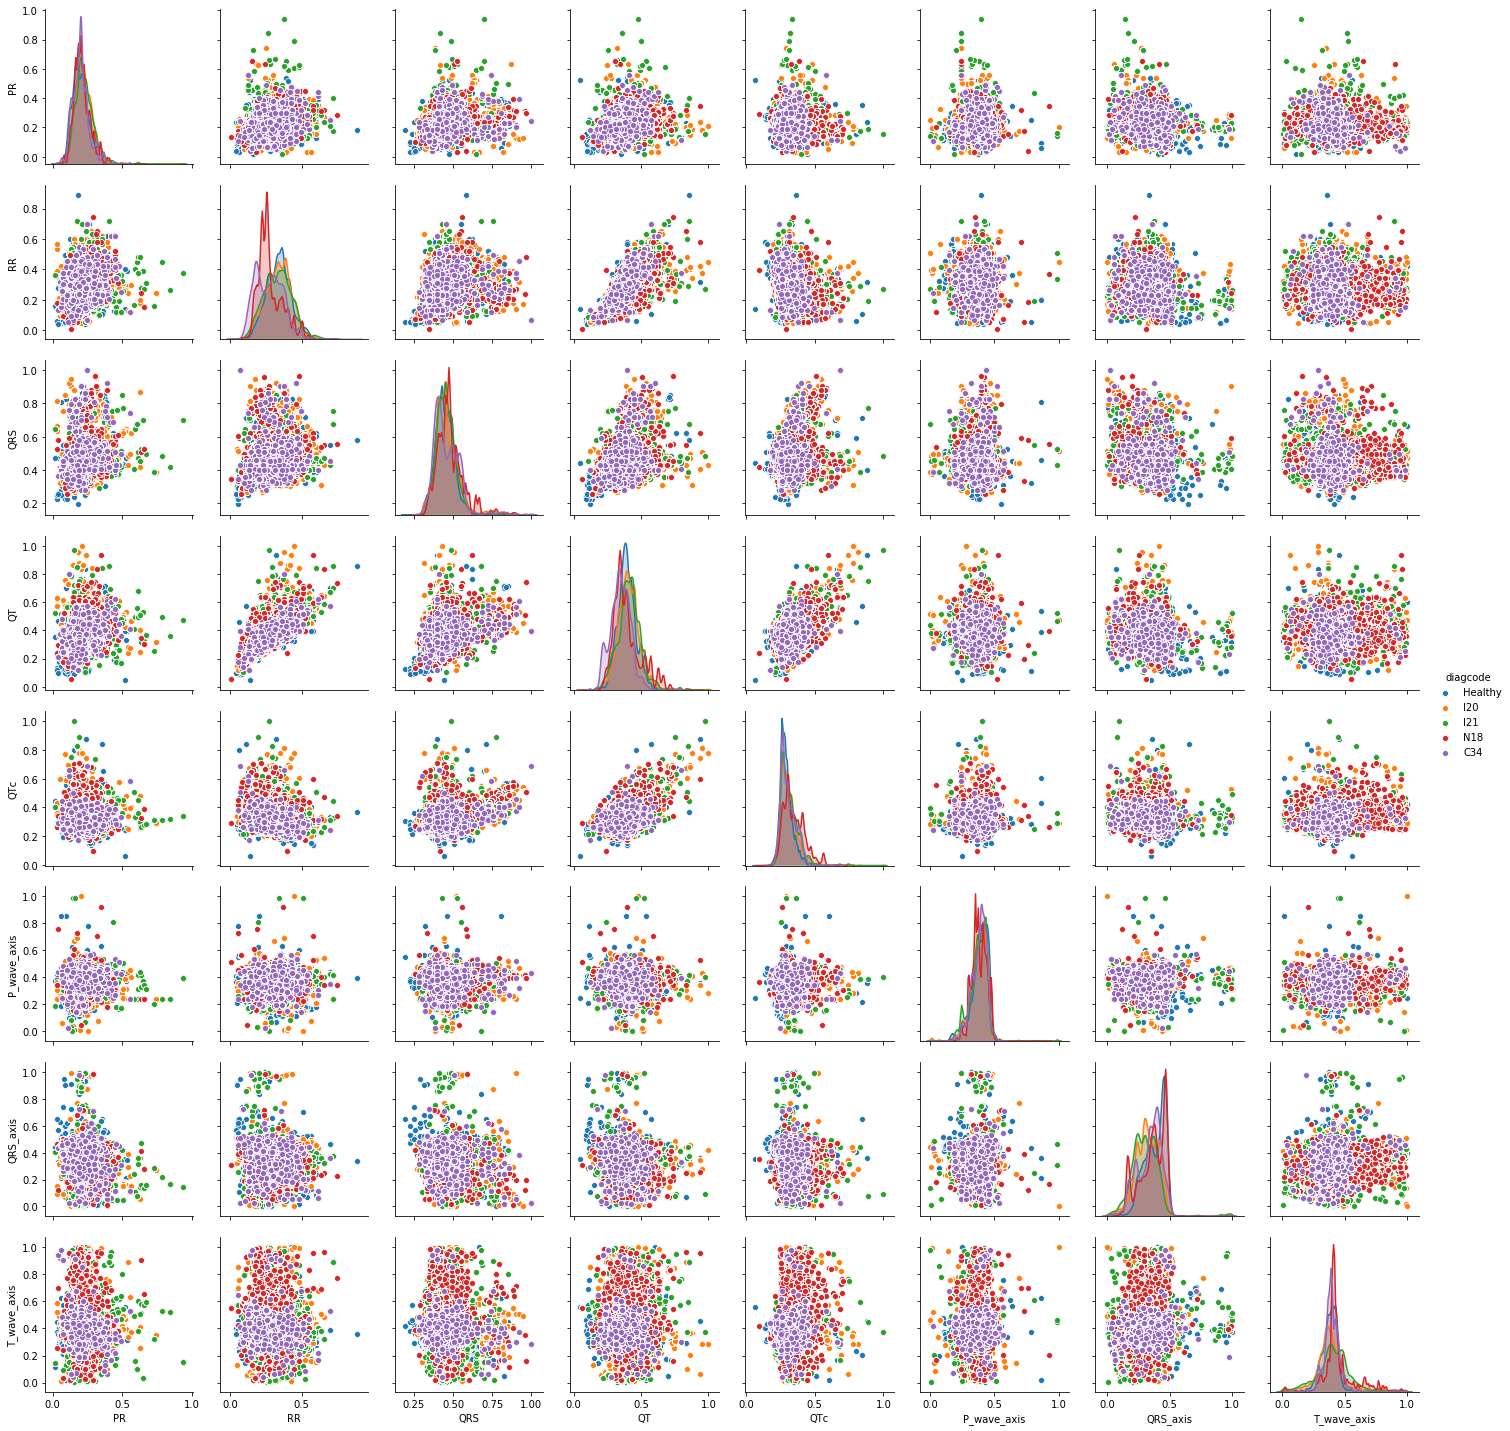

In [42]:
suspected_df = computation_df_3.loc[computation_df_3["diagcode"].isin(suspected_diseases)]
sns.pairplot(suspected_df[feature_names + ["diagcode"]], hue="diagcode")

### To compare let's have a look in some really different from healthy diseases

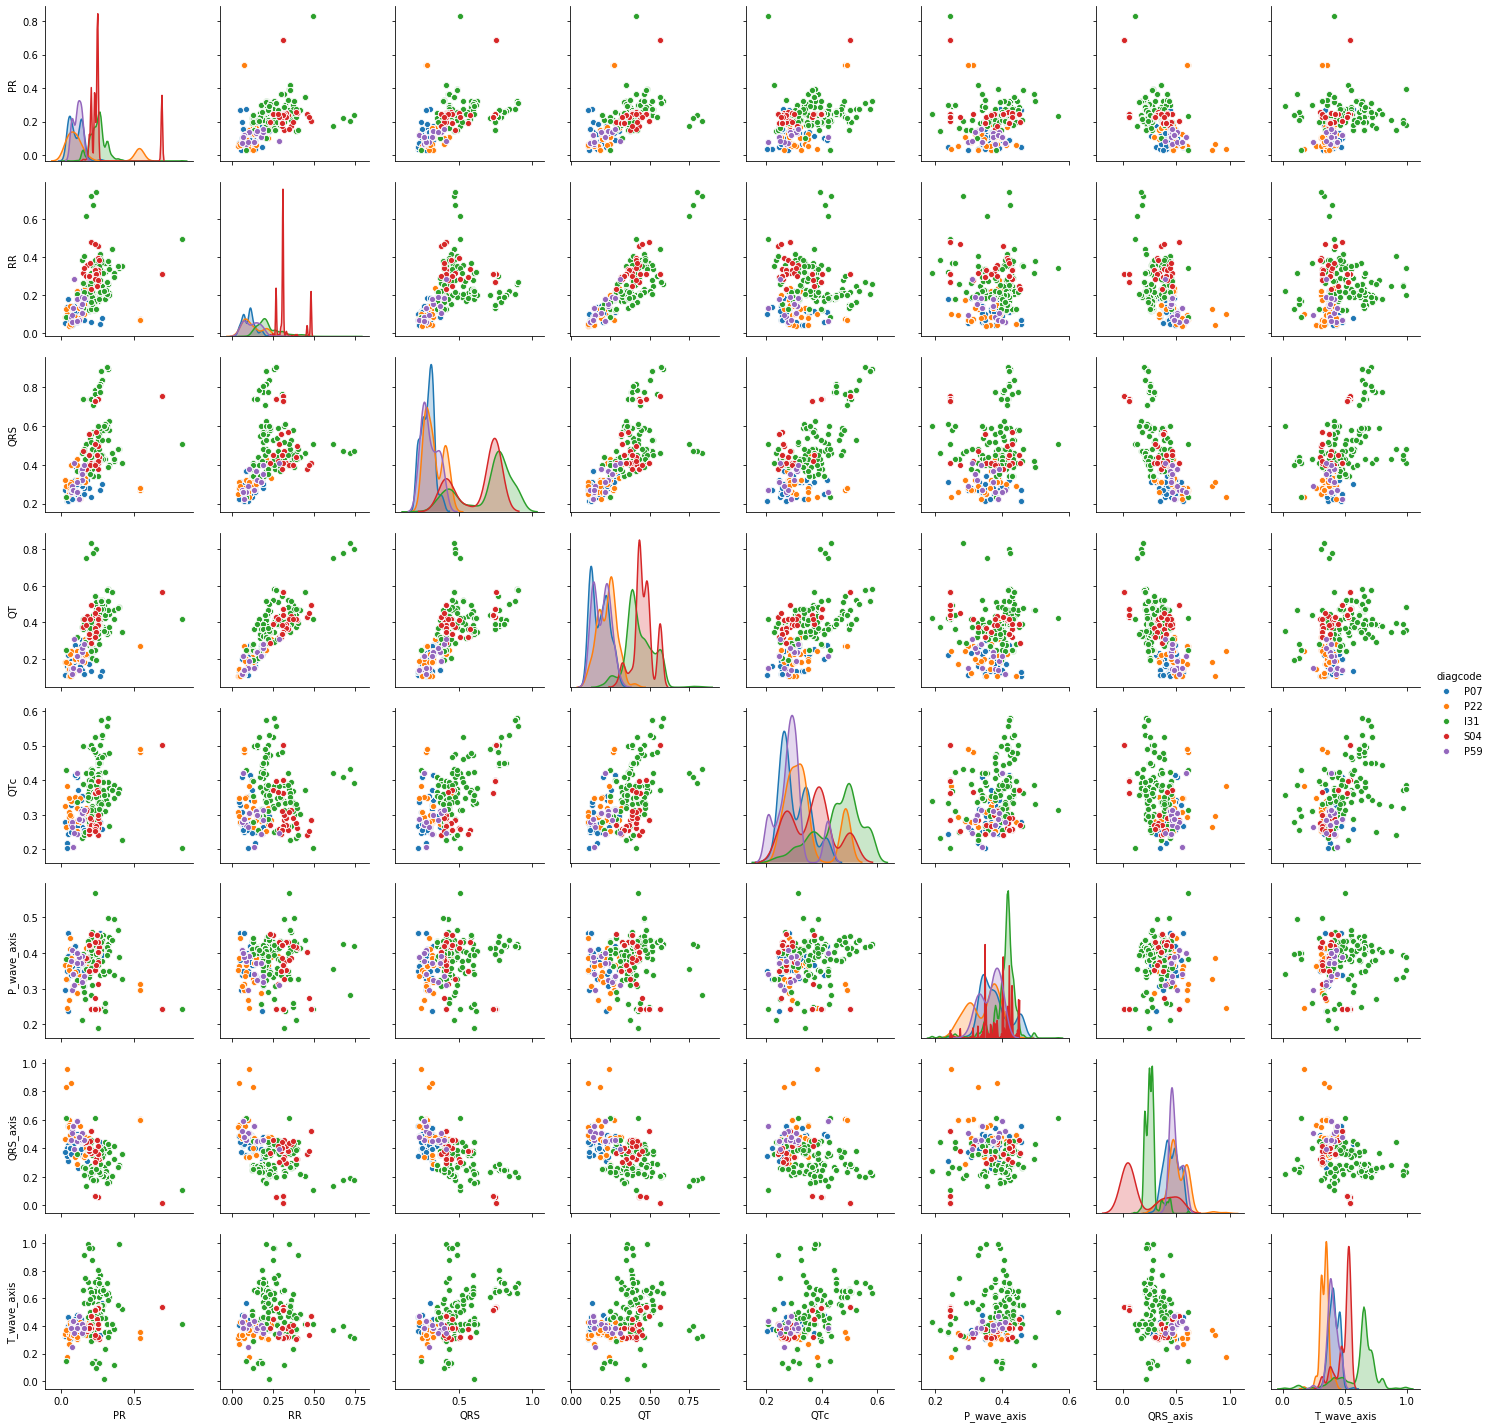

In [36]:
different_diseases = best_diseases[:5]
different_df = computation_df_3.loc[computation_df_3["diagcode"].isin(different_diseases)]
sns.pairplot(different_df[feature_names + ["diagcode"]], hue="diagcode")

Unfortunetely diseases that are thought of as ECG measureable are not different enaugh to put them into classifiers

Name of most simmilar to healthy disease: R05A
Value count of this disease: 215


Text(0.5, 0.98, 'SICK')

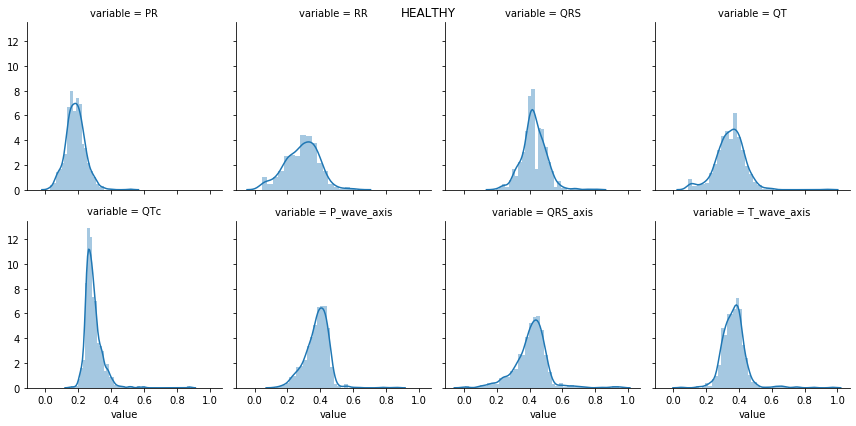

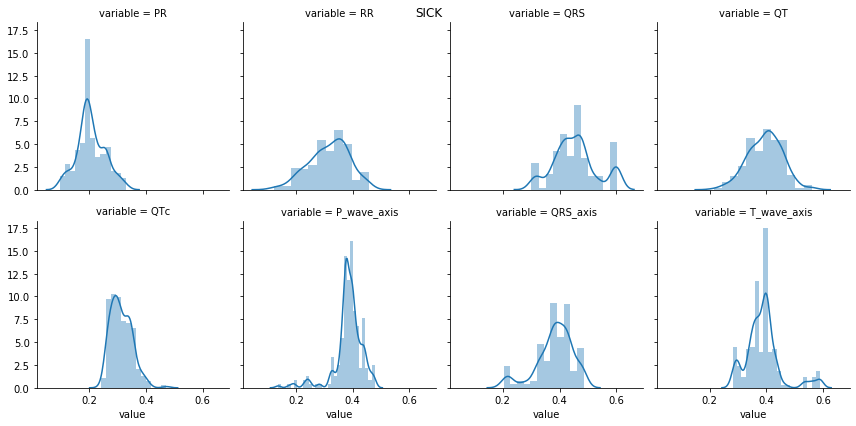

In [44]:
#For example let's take most healthy-looking disease and check its features
#First 2 rows of diagrams are with healthy data, second is with data from hardest_disease
hardest_disease = sorted(most_differing)[len(sorted(most_differing)) - 5][1]
print("Name of most simmilar to healthy disease: %s" %(hardest_disease))
print("Value count of this disease: %d" % (computation_df_3["diagcode"].value_counts()[hardest_disease]))
worst_df = computation_df_3.loc[computation_df_3["diagcode"] == hardest_disease]
worst_df_long = pd.melt(worst_df, value_vars=feature_names)
g = sns.FacetGrid(hlth_df_long, col="variable", col_wrap=4) 
g.map(sns.distplot, "value")
g.fig.suptitle('HEALTHY')
g = sns.FacetGrid(worst_df_long, col="variable", col_wrap=4) 
g.map(sns.distplot, "value")
g.fig.suptitle('SICK')

As we can see there is almost no difference between disease and healthy distributions so there is no classifier that could predict such disease basing only on ECG data. In this dataset appears a lot of disieases not connected with ECG so let's leavy only 100 most easy to differ.

In [71]:
best_diseases.append("Healthy")
better_df = computation_df_3.loc[computation_df_3["diagcode"].isin(best_diseases[:100])]
better_df["diagcode"].value_counts()

I42       6057
I15       4110
I95       3280
N17       2829
R01       2458
          ... 
M84700      56
G70         55
D73         52
H19         52
B09B        50
Name: diagcode, Length: 100, dtype: int64

## Features with smallest variance

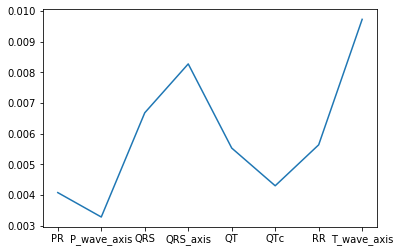

In [34]:
plt.plot(better_df.groupby("diagcode").var().mean())

## Most differing features (most useful in decision tree)

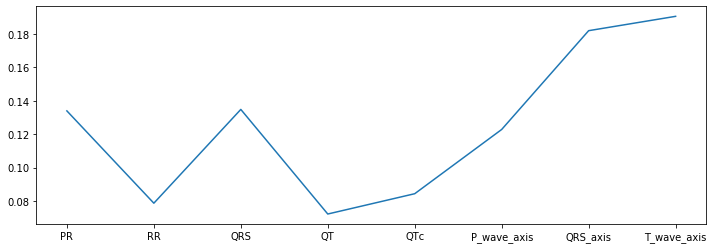

In [35]:
clf = DecisionTreeClassifier()
clf.fit(better_df[feature_names], better_df["diagcode"])
plt.figure(figsize = (12,4))
plt.plot(feature_names, clf.feature_importances_)

# Final stage

In [72]:
msk = np.random.rand(len(better_df)) < 0.8
train_df_3 = better_df[msk]
test_df_3 = better_df[~msk]

In [51]:
#to have comparsion between classifiers and some random guessing let's compute accuracies of guessing diseases
better_df["diagcode"].value_counts() / len(better_df["diagcode"])

I42       0.127947
I15       0.086819
I95       0.069286
N17       0.059759
R01       0.051922
            ...   
M84700    0.001183
G70       0.001162
D73       0.001098
H19       0.001098
B09B      0.001056
Name: diagcode, Length: 100, dtype: float64

In [73]:
testWithKNN(train_df_3, test_df_3, range(1,100,20))

best_k: 1
best accuracy: 0.827418


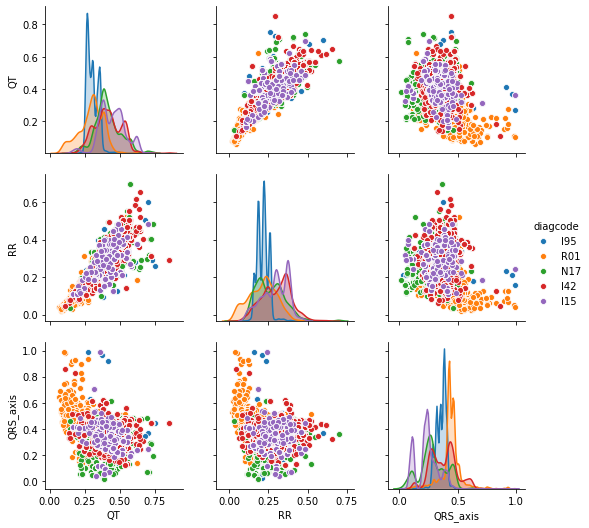

In [45]:
#showing only most helpful distributions
most_common_df = better_df["diagcode"].value_counts()>2000
disieases = list(most_common_df.loc[most_common_df == True].index.unique())
if not "Healthy" in disieases:
    disieases.append("Healthy")
vis_df_3 = better_df.loc[better_df["diagcode"].isin(disieases)]

sns.pairplot(vis_df_3[["QT", "RR", "QRS_axis", "diagcode"]], hue="diagcode") 

In [53]:
#quick test with random forest
clf = RandomForestClassifier(n_jobs = 1, max_depth=20)
clf.fit(train_df_3[feature_names], train_df_3["diagcode"])
preds = clf.predict(test_df_3[feature_names])
print("Accuracy reached with random forest: ", np.mean(preds == test_df_3["diagcode"]))
#trick to release RAM
clf = RandomForestClassifier(n_jobs = 3, max_depth=1, min_samples_split=10)

Accuracy reached with random forest:  0.8469750889679716


## Final classifying
As I succesfully reached good classes distribution and accuracy on simple classifiers I can try classyfying with support vector machine and boosted trees to get final result

In [55]:
#searching for best parameters for SVM with less training data to make computation faster
diagcodes = better_df["diagcode"].unique() 
msk = np.random.rand(len(train_df_3)) < 0.5
train_df_test = train_df_3[msk]
best = 0.0
par = []
for C in np.arange(2.2, 5, 0.2):
    for gamma in np.arange(100,400,100):
        clf = SVC(kernel = 'rbf', C=C, gamma= gamma)
        clf.fit(train_df_test[feature_names], train_df_test["diagcode"].apply(lambda x: np.where(diagcodes == x)[0][0]).to_numpy().astype(np.integer))
        preds = clf.predict(test_df_3[feature_names])
        accuracy = np.mean(preds == test_df_3["diagcode"].apply(lambda x: np.where(diagcodes == x)[0][0]).to_numpy().astype(np.integer))
        if accuracy > best:
            print(best)
            best = accuracy
            par = [C, gamma]
        else: print("---------------------------")
print("Accuracy reached with svm: %f" % (best))
print("Best_params: %f %f" %(par[0], par[1]))

0.0
0.809294536319866
0.8216453841323006
---------------------------
---------------------------
0.8240527527737074
---------------------------
---------------------------
0.8254134393971112
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
0.8262507850115135
---------------------------
---------------------------
0.8265647896169144
---------------------------
---------------------------
0.8266694578187147
---------------------------
Accuracy reached with svm: 0.826355
Best_params: 2.800000 200.000000


In [56]:
#Running svm with best parameters
diagcodes = better_df["diagcode"].unique()
clf = SVC(kernel = 'rbf', C=par[0], gamma= par[1])
clf.fit(train_df_3[feature_names], train_df_3["diagcode"].apply(lambda x: np.where(diagcodes == x)[0][0]).to_numpy().astype(np.integer))
preds = clf.predict(test_df_3[feature_names])
accuracy = np.mean(preds == test_df_3["diagcode"].apply(lambda x: np.where(diagcodes == x)[0][0]).to_numpy().astype(np.integer))
print("Accuracy reached with svm: %f" % (accuracy))    

Accuracy reached with svm: 0.847394


In [61]:
#Boosted trees
diagcodes = better_df["diagcode"].unique() 

clf = GradientBoostingClassifier(max_depth=20)
clf.fit(train_df_3[feature_names], train_df_3["diagcode"].apply(lambda x: np.where(diagcodes == x)[0][0]).to_numpy().astype(np.integer))
preds = clf.predict(test_df_3[feature_names])
accuracy = np.mean(preds == test_df_3["diagcode"].apply(lambda x: np.where(diagcodes == x)[0][0]).to_numpy().astype(np.integer))
print("Accuracy reached with boosted trees: %f" % (accuracy))    

Accuracy reached with boosted trees: 0.829914
